# Parameter identification
Considering the following variables
$$
\mathbf{x} \triangleq \left(\begin{matrix}
T_{\mathrm{in}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{y} \triangleq \left(\begin{matrix}
T_{\mathrm{s}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{u} \triangleq \left(\begin{matrix}
T_{\mathrm{amb}} \\
q_{\mathrm{gen}} \\
\end{matrix}\right),
$$
then the underlying thermal model for a single cell can be expressed as the following MIMO LTI system
$$
\dot{\mathbf{x}} = \left(\begin{matrix}
-\frac{1}{C_p R_T} & \frac{1}{C_p R_T} \\
\frac{1}{C_{\mathrm{air}} R_T} & -\frac{R_{\mathrm{air}} + R_T}{C_{\mathrm{air}} R_{\mathrm{air}} R_T} \\
\end{matrix}\right)\mathbf{x} + \left(\begin{matrix}
0 & \frac{1}{C_p} \\
\frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}} & 0 \\
\end{matrix}\right)\mathbf{u} \\
\mathbf{y} = \left(\begin{matrix}
\frac{R_{\mathrm{out}}}{R_T} & \frac{R_{\mathrm{in}}}{R_T} \\
0 & 1 \\
\end{matrix}\right)\mathbf{x},
$$
where $R_{T} \triangleq R_{\mathrm{in}} + R_{\mathrm{out}}$. Then, an LTI system is identified from the data, from which the thermal parameters are obtained.

In [1]:
from lib_240209_temptest_C6B2 import get_data, TargetNLParams, TargetParams, chamber_pv_std, temp_sensor_std, alert

from collections import namedtuple
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize
from statsmodels.tsa.statespace.varmax import VARMAX


DATA_DIR = os.path.join("240209_temptest_C6B2")
TEMP_IMG_DIR = os.path.join("..", "img_raw")
IMG_DIR = os.path.join("..", "img_raw")
SAVE_FMT = "png"
SAVEFIG_PARAMS = {"dpi": 1000, "bbox_inches": "tight"}
SAVE = True


_TRAINING_CUTOFF = 32000

train_data, eval_data = get_data(3, 2, training_cutoff=_TRAINING_CUTOFF)
t_train, y_train, u_train, x0_train = train_data
t_eval, y_eval, u_eval, x0_eval = eval_data

Appending 'c:\Users\Cristobal\Cosas\Trabajos\CASE\Monorepo\battery-temperature-modelling\src' to path


## Estimation

### VARMAX

In [7]:
model = VARMAX(y_train, u_train, (2, 2), measurement_error=True)

c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [8]:
res = model.fit(maxiter=1000)
print(res.summary())

KeyboardInterrupt: 

In [ ]:
_IDX = 249
a = res.simulate(_IDX, exog=y_eval[:_IDX, :], initial_state=30 * np.ones(8))


c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1784: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


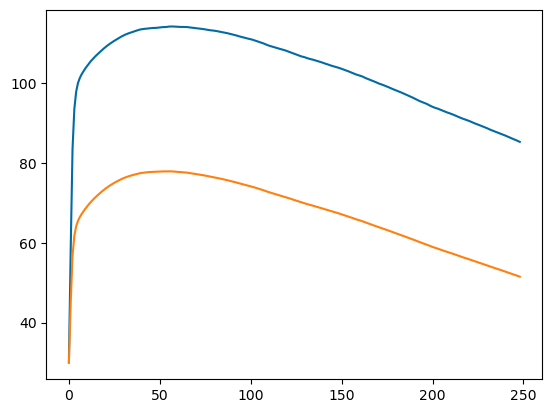

In [ ]:
plt.plot(a)

### DMDc

In [30]:
dt_train = t_train[1] - t_train[0]

states = y_train[:, :-1]
states_shifted = y_train[:, 1:]
inputs = u_train[:, :-1]


result = (states_shifted @ np.linalg.pinv(np.vstack((states, inputs))))
Ad = result[:, :2]
Bd = result[:, 2:]

print(f"Ad = \n{Ad}")
print(f"Bd = \n{Bd}")

A = (Ad - np.eye(2)) / dt_train
B = Bd / dt_train
sys_train = signal.lti(A, B, np.eye(2), np.zeros((2, 2)))

print(f"A = \n{A}")
print(f"B = \n{B}")

poles_d = np.linalg.eig(Ad)[0]
poles = np.linalg.eig(A)[0]
print(f"Discrete poles: {poles_d}")
print(f"Continuous poles: {poles}")
if (np.abs(poles) >= 1).any() or (poles.real > 0).any():
    print("!!! System is unstable !!!")


def target_response_dmdc(u, t, x0, sys):
    y = sys.output(u, t, x0)[1]
    return y


def generate_evaluation_dmdc(expected, u, t, x0):
    def _generate_system(sys) -> float:
        y = target_response_dmdc(u, t, x0, sys)
        error = expected - y
        return expected, y, error
    return _generate_system

Ad = 
[[ 0.99746423  0.00221298]
 [-0.00287009  1.00220908]]
Bd = 
[[0.00033041 0.00021076]
 [0.00067062 0.00018982]]
A = 
[[-0.00233726  0.00203974]
 [-0.00264541  0.00203614]]
B = 
[[0.00030455 0.00019426]
 [0.00061812 0.00017496]]
Discrete poles: [0.99983665+0.00085033j 0.99983665-0.00085033j]
Continuous poles: [-0.00015056+0.00078376j -0.00015056-0.00078376j]


MSE: [13.72795219 20.9423618 ]


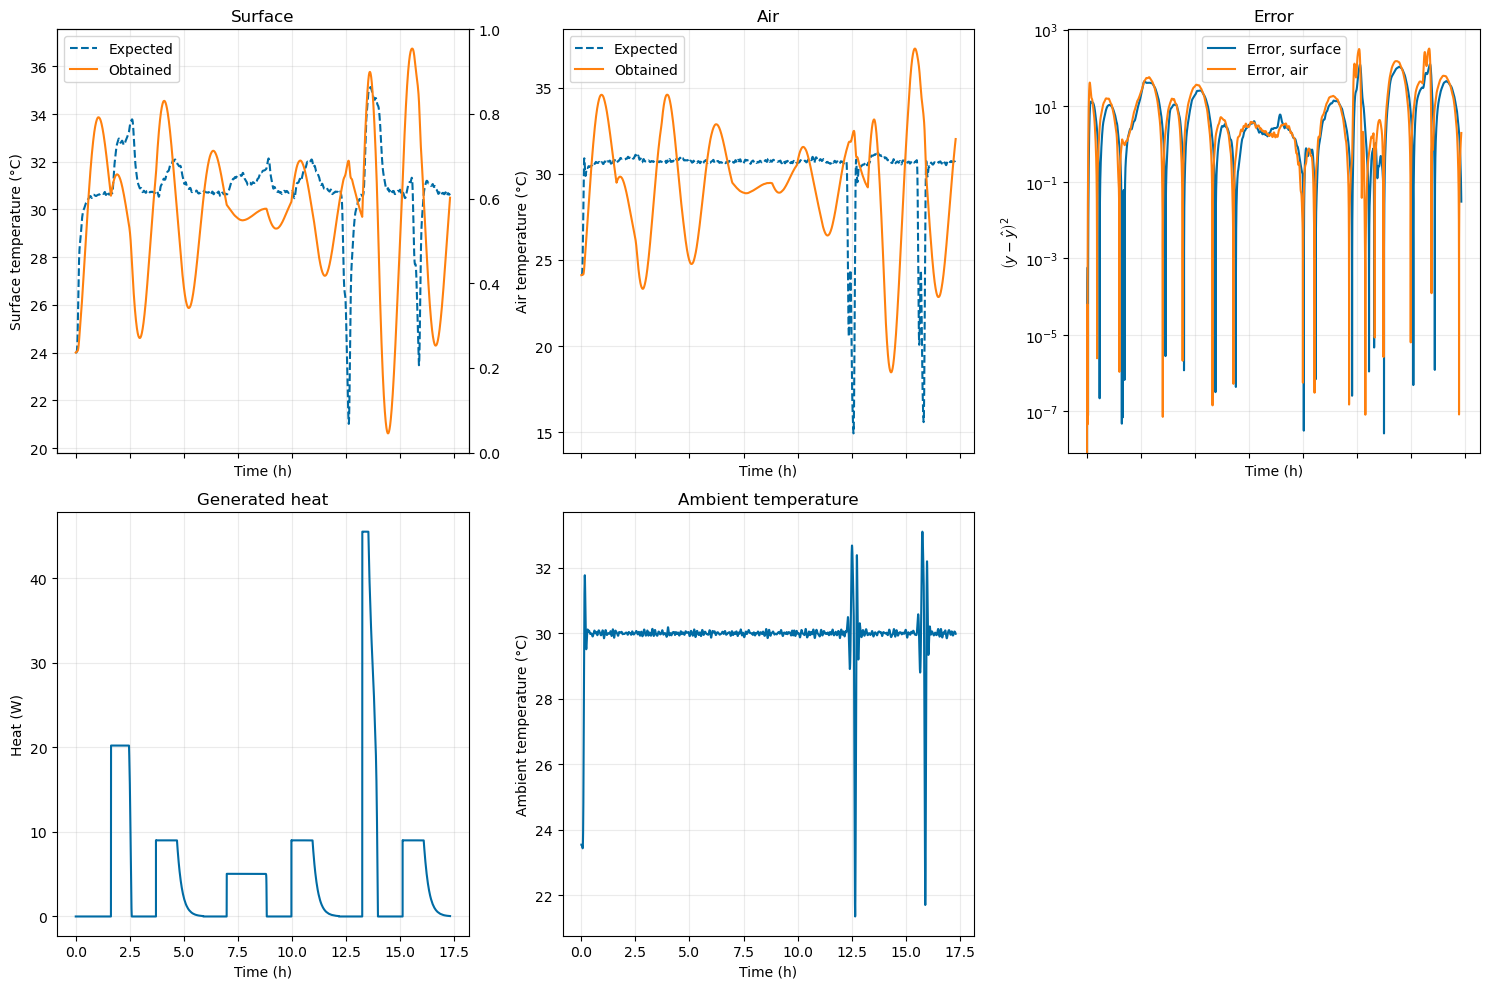

In [33]:
evaluate = generate_evaluation_dmdc(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(sys_train)
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
plt.show()

### Iterative algorithms

In [2]:
PARAMS1 = TargetParams(cp=29.604854855435384, cair=14.403798771439101, rair=0.027775716955409813, rin=34.051506057316416, rout=0.09176371638499373)
PARAMS2 = TargetParams(cp=1751.3595602263526, cair=9976.137906869928, rair=0.031485160985154415, rin=0.45465025035185824, rout=0.0903311199737274)
PARAMS3 = TargetParams(cp=2297.2830850423516, cair=35.62346086817191, rair=0.04769018866592217, rin=0.4268412170392377, rout=0.12689196832834176)
PARAMS4 = TargetParams(cp=2288.8086878520617, cair=40.68543129463231, rair=0.05622811486407936, rin=0.29153746960754423, rout=0.09544187302807855)
BEST_PARAMS = PARAMS4

NL_PARAMS1 = TargetNLParams(cp=4041.8507546808546, cair=79.37562559957331, rair=0.01672734529263066, rin=0.08137752128758086, rout=0.09214799171274607, k=0.38010227820848286)
BEST_NL_PARAMS = NL_PARAMS1


def target_lti_parameters(params: TargetParams | TargetNLParams):
    """Returns the A, B, C, D matrices of the target LTI system"""
    rt = params.rin + params.rout
    a_mat = np.array([
        [-1 / (params.cp * rt), 1 / (params.cp * rt)],
        [1 / (params.cair * rt), -(params.rair + rt) / (params.cair * params.rair * rt)],
    ])
    b_mat = np.array([
        [0, 1 / params.cp],
        [1 / (params.cair * params.rair), 0],
    ])
    c_mat = np.array([
        [params.rout / rt, params.rin / rt],
        [0, 1],
    ])
    d_mat = np.zeros((2, 2))
    return a_mat, b_mat, c_mat, d_mat


def target_lti(params: TargetParams | TargetNLParams) -> signal.StateSpace:
    """Returns an LTI StateSpace instance for the corresponding values"""
    return signal.lti(*target_lti_parameters(params))


def target_response_noisy(u, t, x0, params: TargetParams):
    sys = target_lti(params)
    model_noise = np.random.normal(0, chamber_pv_std, u.shape)
    y = sys.output(u + model_noise, t, x0)[1]
    sensor_noise = np.random.normal(0, temp_sensor_std, y.shape)
    return y + sensor_noise


def target_response(u, t, x0, params: TargetParams):
    sys = target_lti(params)
    y = sys.output(u, t, x0)[1]
    return y


def target_response_noisy_nl(u, t, x0, params: TargetNLParams):
    sys = target_lti(params)
    model_noise = np.random.normal(0, chamber_pv_std, u.shape)
    y = sys.output(u + model_noise, t, x0)[1] + params.k
    sensor_noise = np.random.normal(0, temp_sensor_std, y.shape)
    return y + sensor_noise


def target_response_nl(u, t, x0, params: TargetNLParams):
    sys = target_lti(params)
    y = sys.output(u, t, x0)[1] + params.k
    return y


def generate_l1_error(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        obtained = target_response_noisy(u, t, x0, params)
        error = expected - obtained
        return np.abs(error).sum() / len(t)
    return _generate_system


def generate_l2_error(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        obtained = target_response_noisy(u, t, x0, params)
        error = expected - obtained
        return np.diag(error.conjugate().T @ error).sum() / len(t)
    return _generate_system


def generate_l1_error_nl(expected, u, t, x0):
    def _generate_system(params: TargetNLParams) -> float:
        obtained = target_response_noisy_nl(u, t, x0, params)
        error = expected - obtained
        return np.abs(error).sum() / len(t)
    return _generate_system


def generate_l2_error_nl(expected, u, t, x0):
    def _generate_system(params: TargetNLParams) -> float:
        obtained = target_response_noisy_nl(u, t, x0, params)
        error = expected - obtained
        return np.diag(error.conjugate().T @ error).sum() / len(t)
    return _generate_system


def generate_evaluation(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        y = target_response(u, t, x0, params)
        error = expected - y
        return expected, y, error
    return _generate_system


def generate_evaluation_nl(expected, u, t, x0):
    def _generate_system(params: TargetNLParams) -> float:
        y = target_response_nl(u, t, x0, params)
        error = expected - y
        return expected, y, error
    return _generate_system

In [17]:
# _INITIAL_GUESS = np.array([100, 100, 1, 1, 1])
_INITIAL_GUESS = np.array([*BEST_PARAMS])
error_fn = generate_l2_error(y_train, u_train, t_train, x0_train)

params = optimize.minimize(
    lambda p: error_fn(TargetParams(*p)),
    _INITIAL_GUESS,
    bounds=optimize.Bounds(0, np.inf),
    jac="3-point",
    hess="3-point",
    method="Nelder-Mead",
    options={
        # "maxiter": 10000,
        "disp": True,
    },
)

# params = optimize.basinhopping(
#     lambda p: error_fn(TargetParams(*p)),
#     _INITIAL_GUESS,
#     minimizer_kwargs={
#         "bounds": optimize.Bounds(0, np.inf),
#         "jac": "3-point",
#         "hess": "3-point",
#         "method": "Nelder-Mead",
#         "options": {
#             "disp": True,
#         },
#     },
# )


A, B, C, _ = target_lti_parameters(TargetParams(*params.x))
display(params)
print(f"Final parameters: {TargetParams(*params.x)}")
print(f"A = \n{A}")
print(f"B = \n{B}")
print(f"C = \n{C}")

print(f"Continous poles: {np.linalg.eig(A)[0]}")

if np.linalg.matrix_rank(np.vstack([C, C @ A])) != 2:
    print("!!! SYSTEM IS NOT OBSERVABLE !!!")
alert()

C:\Users\Cristobal\AppData\Local\Temp\ipykernel_10340\425939669.py:6: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  params = optimize.minimize(


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.42368553684100185
             x: [ 2.231e+03  4.360e+01  4.683e-02  2.699e-01  1.085e-01]
           nit: 370
          nfev: 1000
 final_simplex: (array([[ 2.231e+03,  4.360e+01, ...,  2.699e-01,
                         1.085e-01],
                       [ 2.231e+03,  4.360e+01, ...,  2.699e-01,
                         1.085e-01],
                       ...,
                       [ 2.231e+03,  4.360e+01, ...,  2.699e-01,
                         1.085e-01],
                       [ 2.231e+03,  4.360e+01, ...,  2.699e-01,
                         1.085e-01]]), array([ 4.237e-01,  4.254e-01,  4.256e-01,  4.262e-01,
                        4.263e-01,  4.269e-01]))

Final parameters: TargetParams(cp=2231.153968404892, cair=43.59677389382021, rair=0.04683000539866847, rin=0.26986261854463667, rout=0.108474934870501)
A = 
[[-0.00118465  0.00118465]
 [ 0.06062702 -0.55043001]]
B = 
[[0.00000000e+00 4.48198562e-04]
 [4.89802998e-01 0.00000000e+00]]
C = 
[[0.28671469 0.71328531]
 [0.         1.        ]]
Continous poles: [-0.00105392 -0.55056075]


MSE: [1.50558725 5.01519652]


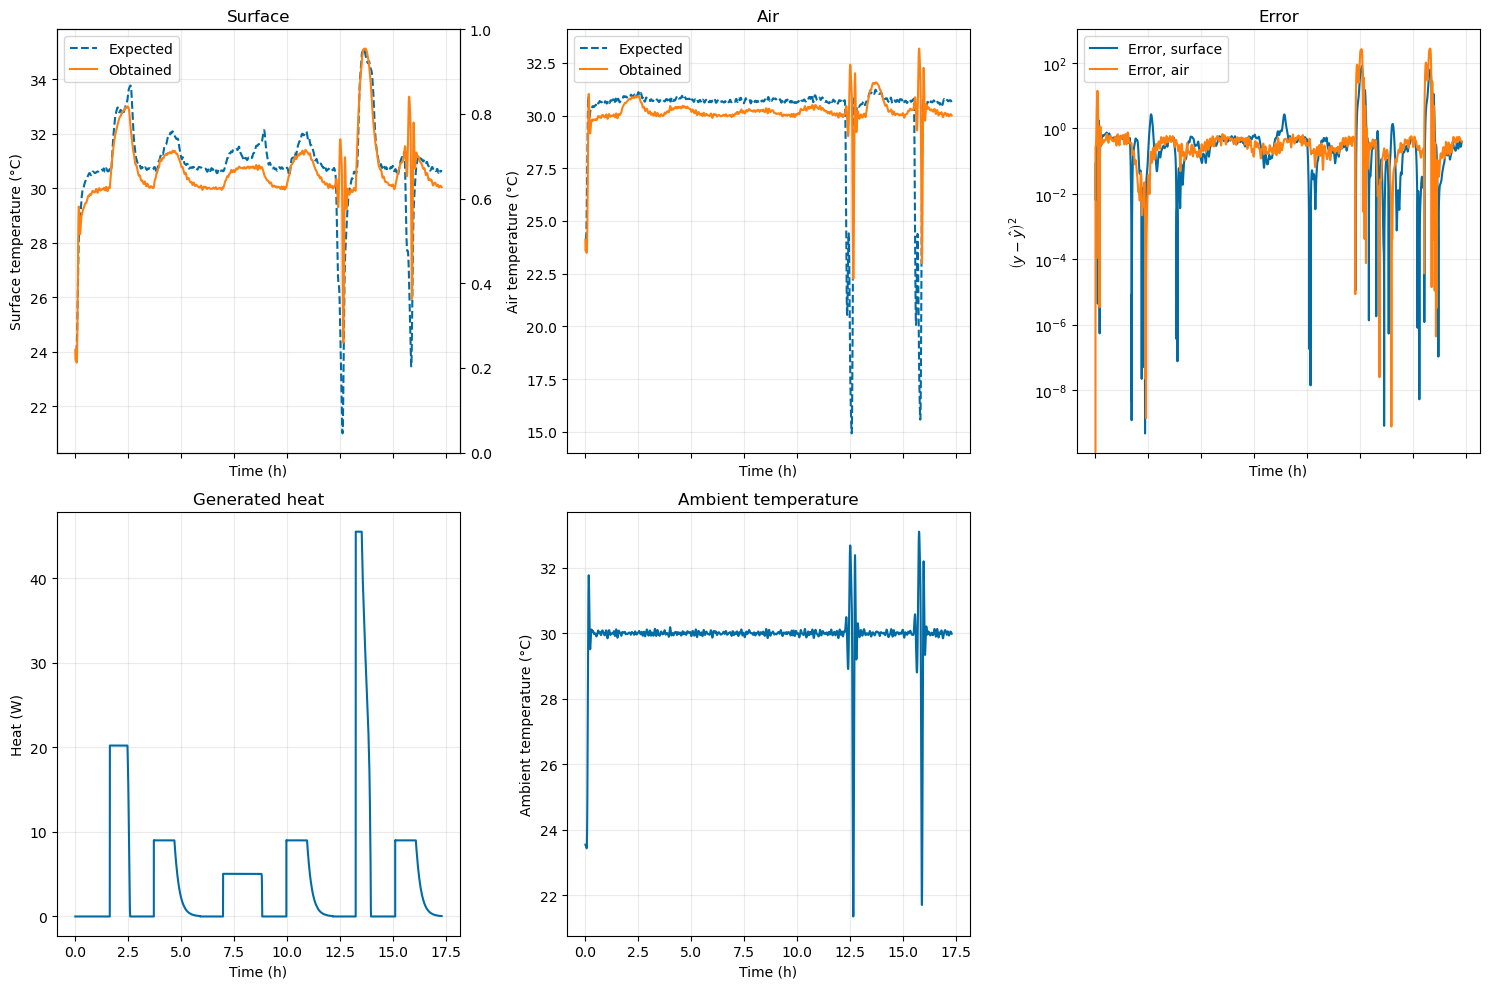

In [18]:
evaluate = generate_evaluation(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(TargetParams(*params.x))
# expected, obtained, error = evaluate(TargetParams(*BEST_PARAMS))
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
plt.show()

In [26]:
# _INITIAL_GUESS = np.array([100, 100, 1, 1, 1])
_INITIAL_GUESS = np.array([*BEST_NL_PARAMS])
error_fn = generate_l2_error_nl(y_train, u_train, t_train, x0_train)

params = optimize.minimize(
    lambda p: error_fn(TargetNLParams(*p)),
    _INITIAL_GUESS,
    bounds=optimize.Bounds(0, np.inf),
    jac="3-point",
    hess="3-point",
    method="Nelder-Mead",
    options={
        "maxiter": 10000,
        "disp": True,
    },
)

# params = optimize.basinhopping(
#     lambda p: error_fn(TargetNLParams(*p)),
#     _INITIAL_GUESS,
#     minimizer_kwargs={
#         "bounds": optimize.Bounds(0, np.inf),
#         "jac": "3-point",
#         "hess": "3-point",
#         "method": "Nelder-Mead",
#         "options": {
#             "disp": True,
#         },
#     },
# )


A, B, C, _ = target_lti_parameters(TargetNLParams(*params.x))
display(params)
print(f"Final parameters: {TargetNLParams(*params.x)}")
print(f"A = \n{A}")
print(f"B = \n{B}")
print(f"C = \n{C}")

print(f"Continous poles: {np.linalg.eig(A)[0]}")

if np.linalg.matrix_rank(np.vstack([C, C @ A])) != 2:
    print("!!! SYSTEM IS NOT OBSERVABLE !!!")
alert()

C:\Users\Cristobal\AppData\Local\Temp\ipykernel_10340\2250896365.py:5: RuntimeWarning: Maximum number of iterations has been exceeded.
  params = optimize.minimize(


       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.22739974083464734
             x: [ 4.042e+03  7.938e+01  1.673e-02  8.138e-02  9.215e-02
                  3.801e-01]
           nit: 10000
          nfev: 27407
 final_simplex: (array([[ 4.042e+03,  7.938e+01, ...,  9.215e-02,
                         3.801e-01],
                       [ 4.042e+03,  7.938e+01, ...,  9.215e-02,
                         3.801e-01],
                       ...,
                       [ 4.042e+03,  7.938e+01, ...,  9.215e-02,
                         3.801e-01],
                       [ 4.042e+03,  7.938e+01, ...,  9.215e-02,
                         3.801e-01]]), array([ 2.274e-01,  2.288e-01,  2.290e-01,  2.292e-01,
                        2.293e-01,  2.293e-01,  2.296e-01]))

Final parameters: TargetNLParams(cp=4041.8507546808546, cair=79.37562559957331, rair=0.01672734529263066, rin=0.08137752128758086, rout=0.09214799171274607, k=0.38010227820848286)
A = 
[[-0.00142579  0.00142579]
 [ 0.07260215 -0.82575967]]
B = 
[[0.00000000e+00 2.47411411e-04]
 [7.53157520e-01 0.00000000e+00]]
C = 
[[0.53103426 0.46896574]
 [0.         1.        ]]
Continous poles: [-0.00130024 -0.82588523]


MSE: [1.51033691 5.01061032]


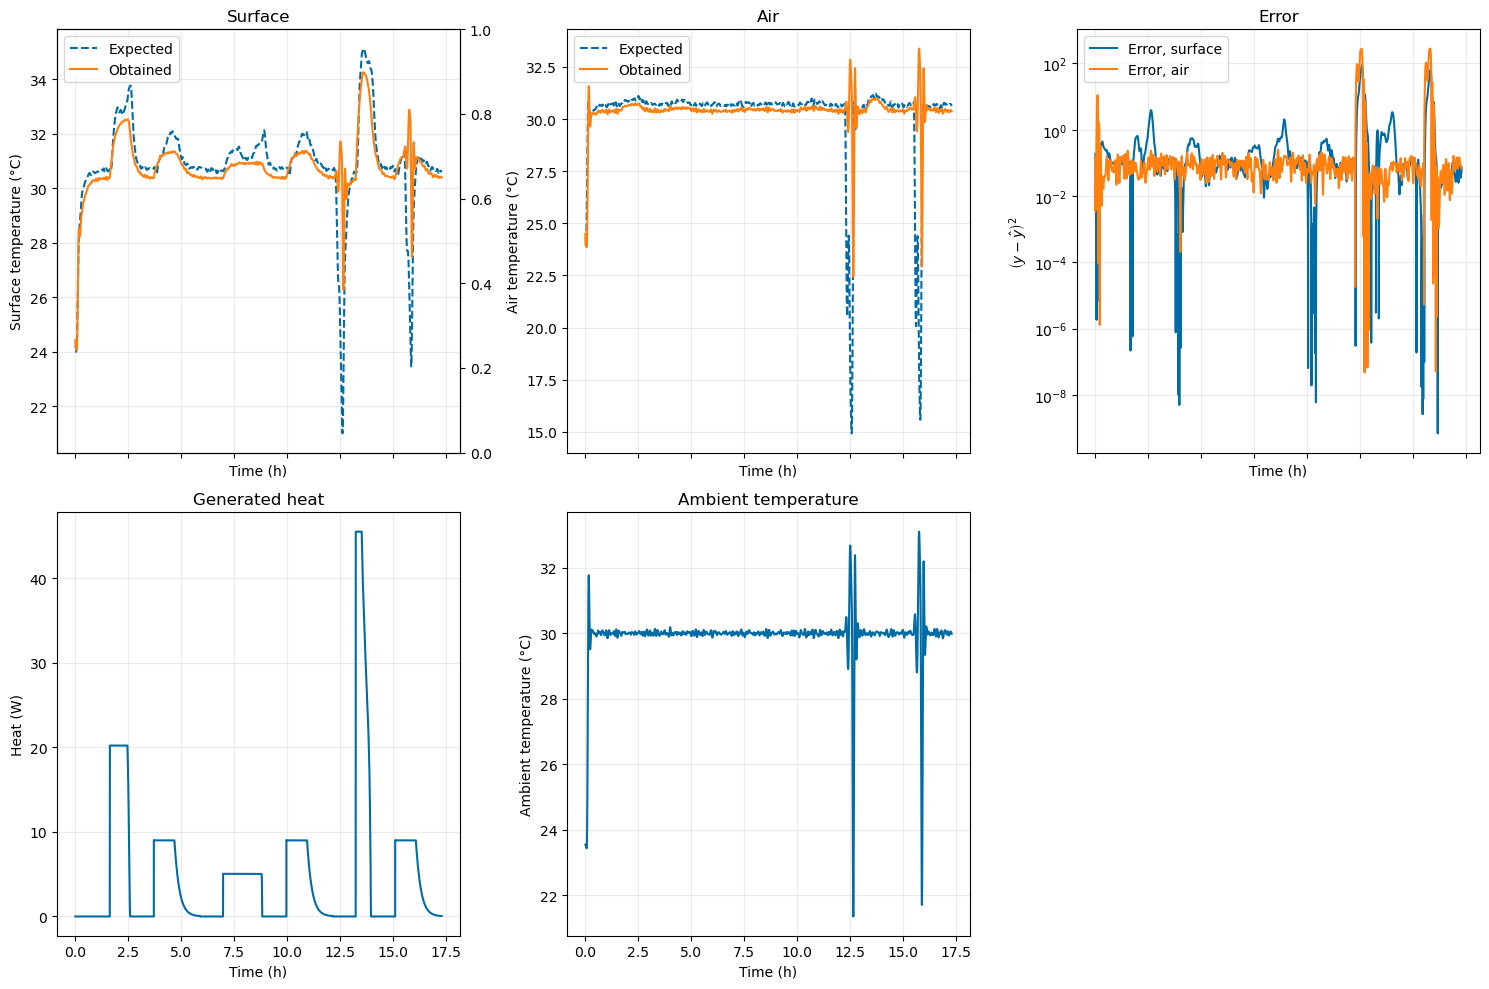

In [27]:
evaluate = generate_evaluation_nl(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(TargetNLParams(*params.x))
# expected, obtained, error = evaluate(TargetNLParams(*BEST_PARAMS_NL))
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
plt.show()

### System decoupling & iterative algorithms
The decoupling is by taking the presented LTI system and, for each different measurement, establish a one dimensional LTI system where the other temperature is an input. When doing this, considering $R_T \triangleq R_{\mathrm{in}} + R_{\mathrm{out}}$, the first system, which models the internal and surface temperature, corresponds to
$$
x^{(1)} \triangleq T_{\mathrm{in}} \quad y^{(1)} \triangleq T_{\mathrm{s}} \quad \mathbf{u}^{(1)} \triangleq \left(
    \begin{matrix}
        T_{\mathrm{air}} \\
        q_{\mathrm{gen}}
    \end{matrix}
\right) \\

\dot{x}^{(1)} = -\frac{1}{C_p R_T} x^{(1)} + \left(
    \begin{matrix}
        \frac{1}{C_p R_T} & \frac{1}{C_p}
    \end{matrix}
\right)\mathbf{u}^{(1)} \\
y^{(1)} = \frac{R_{\mathrm{out}}}{R_T}x^{(1)} + \left(
    \begin{matrix}
        \frac{R_{\mathrm{in}}}{R_T} & 0
    \end{matrix}
\right)\mathbf{u}^{(1)},
$$
where we define
$$
A^{(1)} \triangleq -\frac{1}{C_p R_T} \quad \mathbf{B}^{(1)} \triangleq \left(
    \begin{matrix}
        \frac{1}{C_p R_T} & \frac{1}{C_p}
    \end{matrix}
\right) \quad C^{(1)} \triangleq \frac{R_{\mathrm{out}}}{R_T} \quad \mathbf{D}^{(1)} \triangleq \left(
    \begin{matrix}
        \frac{R_{\mathrm{in}}}{R_T} & 0
    \end{matrix}
\right).
$$

The second system, which models the dynamics of the air temperature, is given by
$$
x^{(2)} \triangleq T_{\mathrm{air}} \quad y^{(2)} \triangleq T_{\mathrm{air}} \quad \mathbf{u}^{(2)} \triangleq \left(
    \begin{matrix}
        T_{\mathrm{s}} \\
        T_{\mathrm{amb}}
    \end{matrix}
\right) \\

\dot{x}^{(2)} = -\left(\frac{1}{C_{\mathrm{air}} R_{\mathrm{out}}} + \frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}}\right) x^{(2)} + \left(
    \begin{matrix}
        \frac{1}{C_{\mathrm{air}} R_{\mathrm{out}}} & \frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}}
    \end{matrix}
\right)\mathbf{u}^{(2)} \\
y^{(2)} = x^{(2)},
$$
where we define
$$
A^{(2)} \triangleq -\left(\frac{1}{C_{\mathrm{air}} R_{\mathrm{out}}} + \frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}}\right) \quad \mathbf{B}^{(2)} \triangleq \left(
    \begin{matrix}
        \frac{1}{C_{\mathrm{air}} R_{\mathrm{out}}} & \frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}}
    \end{matrix}
\right) \quad C^{(2)} \triangleq 1 \quad \mathbf{D}^{(2)} \triangleq 0.
$$

In [2]:
LTIParams = namedtuple("LTIParams", "a b c d")


def lti1_params(p: TargetParams) -> LTIParams:
    rt = p.rin + p.rout
    a = -1 / (p.cp * rt)
    b = np.array([1 / (p.cp * rt), 1 / p.cp])
    c = p.rout / rt
    d = np.array([p.rin / rt, 0])
    return LTIParams(a, b, c, d)


def lti2_params(p: TargetParams) -> LTIParams:
    rt = p.rin + p.rout
    a = -1 / (p.cair * p.rout) - 1 / (p.cair * p.rair)
    b = np.array([1 / (p.cair * p.rout), 1 / (p.cair * p.rair)])
    c = 1
    d = np.array([0, 0])
    return LTIParams(a, b, c, d)


def build_tf(a, b, c, d):
    return signal.lti([d, c * b - a * d], [1, -a])


def system_tf(a, b_mat, c, d_mat):
    return [build_tf(a, b, c, d) for b, d in zip(b_mat, d_mat)]


def sys1_response(u, y, t, x0, params: TargetParams):
    tf1, tf2 = system_tf(*lti1_params(params))
    return tf1.output(y[:, 1], t, x0[0])[1] + tf2.output(u[:, 1], t, x0[0])[1]


def sys2_response(u, y, t, x0, params: TargetParams):
    tf1, tf2 = system_tf(*lti2_params(params))
    return tf1.output(y[:, 0], t, x0[1])[1] + tf2.output(u[:, 0], t, x0[1])[1]


def generate_sys1(u, y, x0):
    def _generate_system(t, *params) -> float:
        return sys1_response(u, y, t, x0, TargetParams(*params))
    return _generate_system


def generate_sys2(u, y, x0):
    def _generate_system(t, *params) -> float:
        return sys2_response(u, y, t, x0, TargetParams(*params))
    return _generate_system


def generate_l2_sys1(expected, u, y, t, x0):
    def _generate_system(params: TargetParams) -> float:
        obtained = sys1_response(u, y, t, x0, params)
        error = expected - obtained
        return np.diag(error.conjugate().T @ error).sum() / len(t)
    return _generate_system


def generate_l2_sys2(expected, u, y, t, x0):
    def _generate_system(params: TargetParams) -> float:
        obtained = sys2_response(u, y, t, x0, params)
        error = expected - obtained
        return np.diag(error.conjugate().T @ error).sum() / len(t)
    return _generate_system


def generate_evaluation1(expected, u, y, t, x0):
    sys = generate_sys1(u, y, x0)
    def _generate_system(params: TargetParams) -> float:
        out = sys(t, *params)
        error = expected - out
        return expected, out, error
    return _generate_system


def generate_evaluation2(expected, u, y, t, x0):
    sys = generate_sys2(u, y, x0)
    def _generate_system(params: TargetParams) -> float:
        out = sys(t, *params)
        error = expected - out
        return expected, out, error
    return _generate_system


# Functions for evaluation


def target_lti_parameters(params: TargetParams | TargetNLParams):
    """Returns the A, B, C, D matrices of the target LTI system"""
    rt = params.rin + params.rout
    a_mat = np.array([
        [-1 / (params.cp * rt), 1 / (params.cp * rt)],
        [1 / (params.cair * rt), -(params.rair + rt) / (params.cair * params.rair * rt)],
    ])
    b_mat = np.array([
        [0, 1 / params.cp],
        [1 / (params.cair * params.rair), 0],
    ])
    c_mat = np.array([
        [params.rout / rt, params.rin / rt],
        [0, 1],
    ])
    d_mat = np.zeros((2, 2))
    return a_mat, b_mat, c_mat, d_mat


def target_lti(params: TargetParams | TargetNLParams) -> signal.StateSpace:
    """Returns an LTI StateSpace instance for the corresponding values"""
    return signal.lti(*target_lti_parameters(params))


def target_response(u, t, x0, params: TargetParams):
    sys = target_lti(params)
    y = sys.output(u, t, x0)[1]
    return y


def generate_evaluation(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        y = target_response(u, t, x0, params)
        error = expected - y
        return expected, y, error
    return _generate_system

In [3]:
params1, cov1 = optimize.curve_fit(generate_sys1(u_train, y_train, x0_train), t_train, y_train[:, 0], np.ones(5))
TargetParams(*params1)

c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


TargetParams(cp=1065.1662544260266, cair=1.0, rair=1.0, rin=0.7974578944928027, rout=0.09760495174185055)

MSE: [1.3298538813149292, 0.7182947374029589]


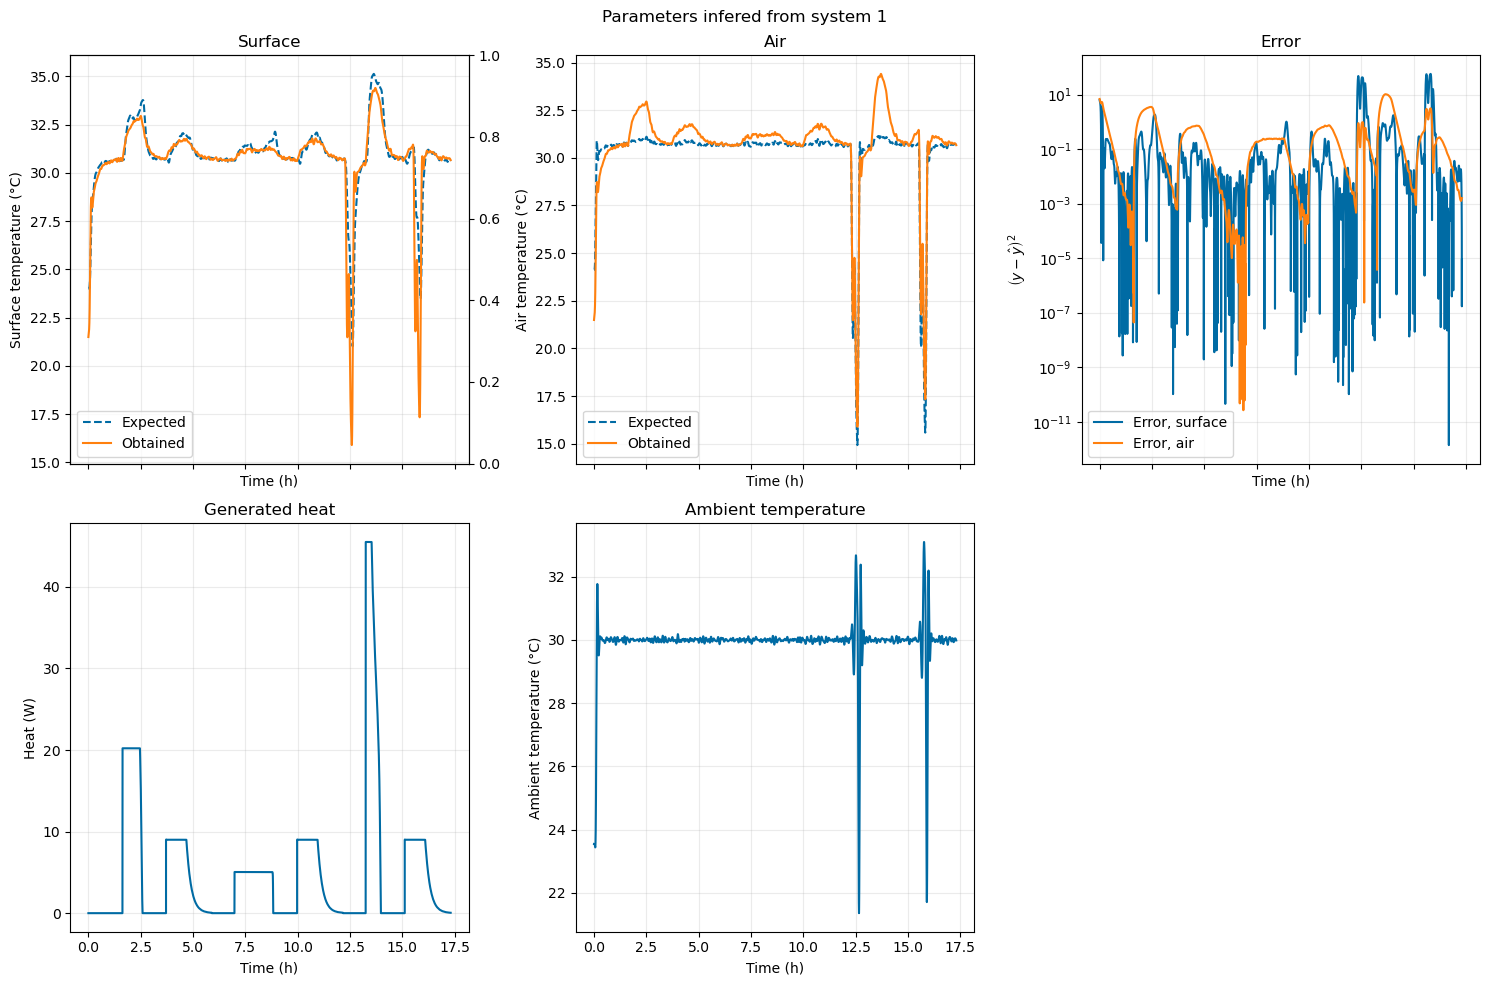

In [4]:
evaluate_sf = generate_evaluation1(y_eval[:, 0], u_eval, y_eval, t_eval, x0_eval)
expected_sf, obtained_sf, error_sf = evaluate_sf(TargetParams(*params1))
error_sf_square = error_sf ** 2
mse_sf = error_sf.conjugate().T @ error_sf / len(error_sf)
evaluate_air = generate_evaluation1(y_eval[:, 1], u_eval, y_eval, t_eval, x0_eval)
expected_air, obtained_air, error_air = evaluate_air(TargetParams(*params1))
error_air_square = error_air ** 2
mse_air = error_air.conjugate().T @ error_air / len(error_air)
print(f"MSE: {[mse_sf, mse_air]}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected_sf, label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained_sf, label="Obtained")
ax2.plot(t_eval / 3600, expected_air, label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained_air, label="Obtained")
ax3.plot(t_eval / 3600, error_sf_square, label="Error, surface")
ax3.plot(t_eval / 3600, error_air_square, label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")
fig.suptitle("Parameters infered from system 1")

fig.tight_layout()

if SAVE:
    fig.savefig(os.path.join(IMG_DIR, f"decoupled-sys1.{SAVE_FMT}"), **SAVEFIG_PARAMS)
plt.show()

In [5]:
def _wrapper(u, y, x0, params):
    def _fn(t, cair, rair):
        return generate_sys2(u, y, x0)(t, params[0], cair, rair, params[3], params[4])
    return _fn


_temp_params2, cov2 = optimize.curve_fit(_wrapper(u_train, y_train, x0_train, params1), t_train, y_train[:, 1], np.ones(2), bounds=(0, np.inf))
params2 = np.array([params1[0], *_temp_params2, params1[3], params1[4]])
TargetParams(*params2)

TargetParams(cp=1065.1662544260266, cair=29.112689168988226, rair=0.04991982315017444, rin=0.7974578944928027, rout=0.09760495174185055)

MSE: [1.3298538813149292, 3.604144278500962]


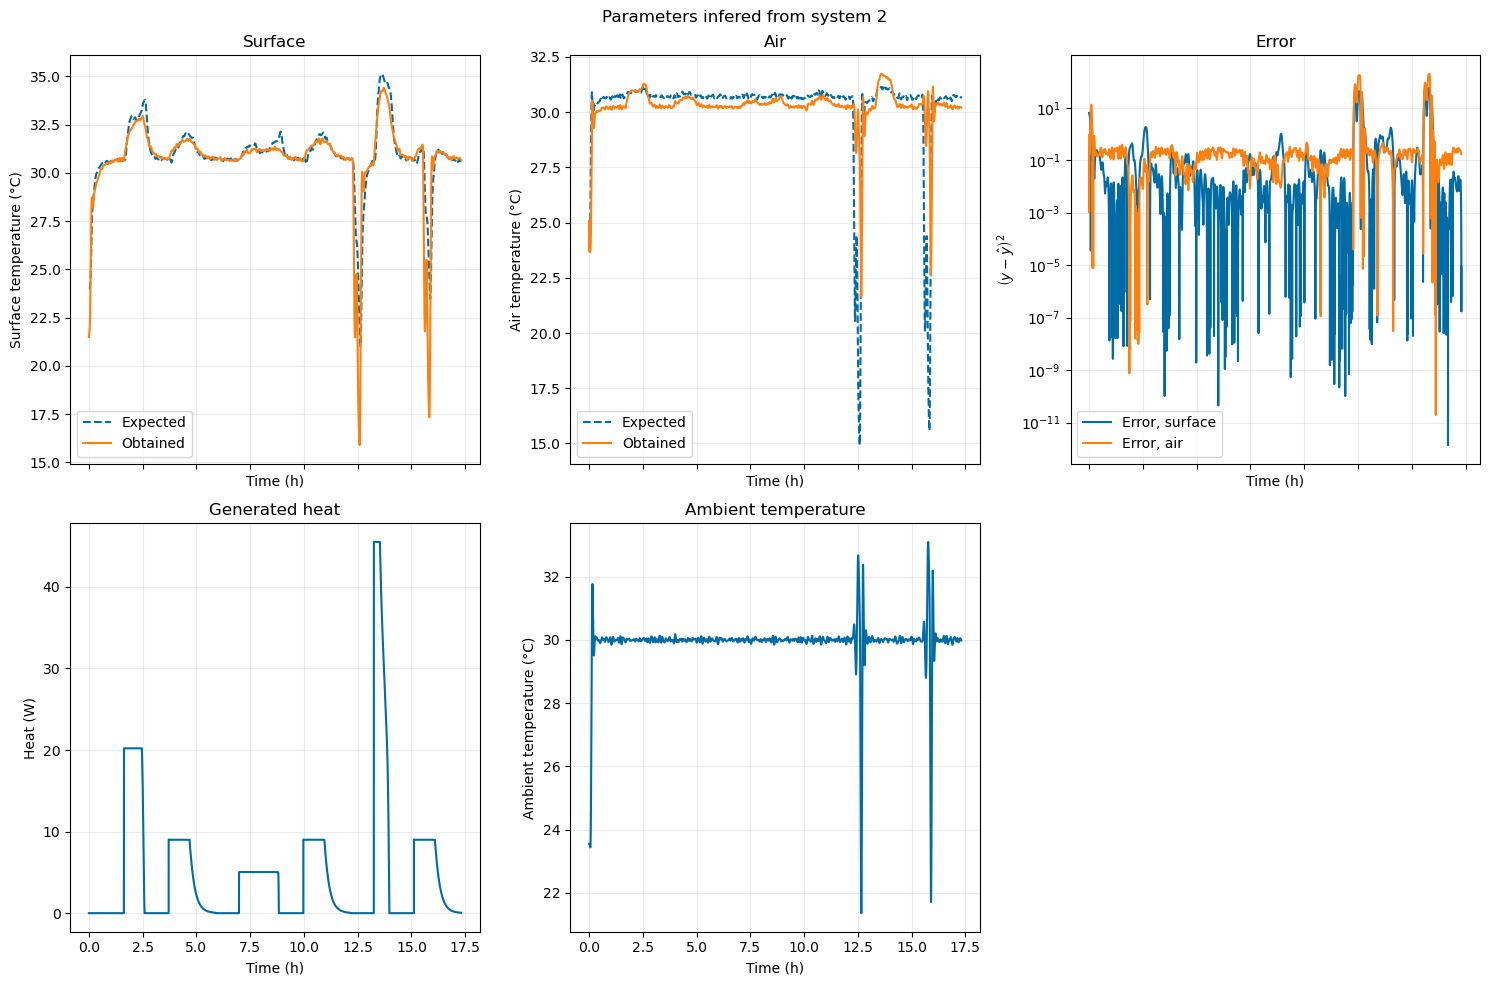

In [6]:
evaluate_sf = generate_evaluation1(y_eval[:, 0], u_eval, y_eval, t_eval, x0_eval)
expected_sf, obtained_sf, error_sf = evaluate_sf(TargetParams(*params2))
error_sf_square = error_sf ** 2
mse_sf = error_sf.conjugate().T @ error_sf / len(error_sf)
evaluate_air = generate_evaluation2(y_eval[:, 1], u_eval, y_eval, t_eval, x0_eval)
expected_air, obtained_air, error_air = evaluate_air(TargetParams(*params2))
error_air_square = error_air ** 2
mse_air = error_air.conjugate().T @ error_air / len(error_air)
print(f"MSE: {[mse_sf, mse_air]}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1.plot(t_eval / 3600, expected_sf, label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained_sf, label="Obtained")
ax2.plot(t_eval / 3600, expected_air, label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained_air, label="Obtained")
ax3.plot(t_eval / 3600, error_sf_square, label="Error, surface")
ax3.plot(t_eval / 3600, error_air_square, label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")
fig.suptitle("Parameters infered from system 2")

fig.tight_layout()
if SAVE:
    fig.savefig(os.path.join(IMG_DIR, f"decoupled-sys2.{SAVE_FMT}"), **SAVEFIG_PARAMS)
plt.show()

MSE: [1.55636412 5.05334951]


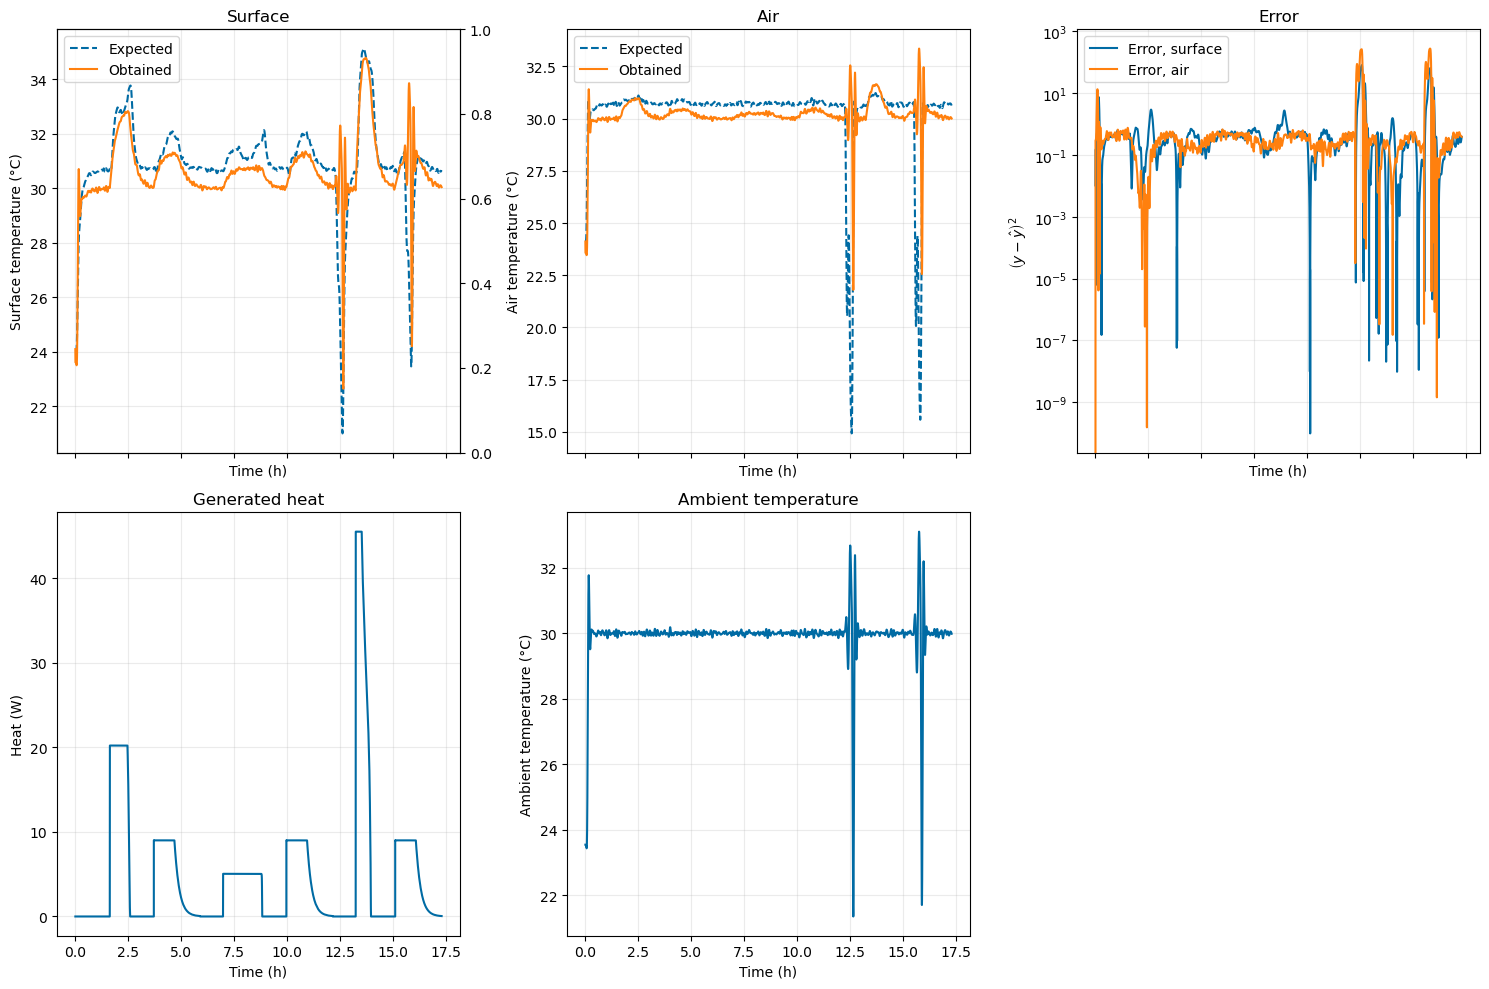

In [7]:
evaluate = generate_evaluation(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(TargetParams(*params2))
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
if SAVE:
    fig.savefig(os.path.join(IMG_DIR, f"decoupled-lti.{SAVE_FMT}"), **SAVEFIG_PARAMS)
plt.show()